In [1]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

# Import tf_text to load the ops used by the tokenizer saved model
import tensorflow_text  # pylint: disable=unused-import

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [3]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
    print(pt_examples)

tf.Tensor(
[b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'
 b'mas e se estes fatores fossem ativos ?'
 b'mas eles n\xc3\xa3o tinham a curiosidade de me testar .'], shape=(3,), dtype=string)


In [4]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'.\\ted_hrlr_translate_pt_en_converter.zip'

In [5]:
tokenizers = tf.saved_model.load(model_name)

In [6]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [7]:
MAX_TOKENS=500
def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

In [8]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

In [9]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [10]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [11]:
import numpy as np

In [12]:
np.nonzero(np.array([1,2,3,0,4]))

(array([0, 1, 2, 4], dtype=int64),)

In [13]:
a=np.array([[1,2,3,0,4],[0,0,3,7,8]])
np.where(a!=0,0,1)

array([[0, 0, 0, 1, 0],
       [1, 1, 0, 0, 0]])

In [14]:
def create_padding_mask(seq):
    npseq = seq.numpy()
    
    npmaskseq = np.where(npseq!=0,0,1)
    tfseq = tf.convert_to_tensor(npmaskseq,dtype=tf.float32)
    
    tfseq = tfseq[:,tf.newaxis,tf.newaxis,:]
    return tfseq

In [15]:
create_padding_mask(tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]]))

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [16]:
1*8*9*64

4608

In [17]:
x=np.arange(4608).reshape([64,8,9])

In [18]:
np.transpose(x).shape

(9, 8, 64)

In [19]:
tf.matmul(x,x,transpose_b=True)

<tf.Tensor: shape=(64, 8, 8), dtype=int32, numpy=
array([[[      204,       528,       852, ...,      1824,      2148,
              2472],
        [      528,      1581,      2634, ...,      5793,      6846,
              7899],
        [      852,      2634,      4416, ...,      9762,     11544,
             13326],
        ...,
        [     1824,      5793,      9762, ...,     21669,     25638,
             29607],
        [     2148,      6846,     11544, ...,     25638,     30336,
             35034],
        [     2472,      7899,     13326, ...,     29607,     35034,
             40461]],

       [[    52044,     58200,     64356, ...,     82824,     88980,
             95136],
        [    58200,     65085,     71970, ...,     92625,     99510,
            106395],
        [    64356,     71970,     79584, ...,    102426,    110040,
            117654],
        ...,
        [    82824,     92625,    102426, ...,    131829,    141630,
            151431],
        [    88980,   

In [20]:
np.transpose(np.arange(512*3*2).reshape(2,3,512),axes=[1,0,2])

array([[[   0,    1,    2, ...,  509,  510,  511],
        [1536, 1537, 1538, ..., 2045, 2046, 2047]],

       [[ 512,  513,  514, ..., 1021, 1022, 1023],
        [2048, 2049, 2050, ..., 2557, 2558, 2559]],

       [[1024, 1025, 1026, ..., 1533, 1534, 1535],
        [2560, 2561, 2562, ..., 3069, 3070, 3071]]])

In [21]:
np.arange(512*3*2).reshape(2,3,512)

array([[[   0,    1,    2, ...,  509,  510,  511],
        [ 512,  513,  514, ..., 1021, 1022, 1023],
        [1024, 1025, 1026, ..., 1533, 1534, 1535]],

       [[1536, 1537, 1538, ..., 2045, 2046, 2047],
        [2048, 2049, 2050, ..., 2557, 2558, 2559],
        [2560, 2561, 2562, ..., 3069, 3070, 3071]]])

In [22]:
def self_attention(q,k,v,depth,mask=None):
    scaled_attention = tf.matmul(q,k,transpose_b=True)/tf.math.sqrt(tf.cast(depth,tf.float32))
    if mask is not None:
        scaled_attention = scaled_attention + mask*(-1e9)
    
    attentions_wts = tf.nn.softmax(scaled_attention,axis=-1)
    weighted_values = tf.matmul(attentions_wts,v)
    return attentions_wts,weighted_values
    

In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_heads):
        super(MultiHeadAttention, self).__init__()
        self.wq = tf.keras.layers.Dense(d_model) #d_model  = typically 512
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.num_heads = num_heads
        self.depth = d_model//num_heads
        self.dense = tf.keras.layers.Dense(d_model)
        self.d_model = d_model
        
    def split_heads(self,token_batch):
        self.batch_size = tf.shape(token_batch)[0]
        seq_len = tf.shape(token_batch)[1]
        resized_token_batch = tf.reshape(token_batch,[self.batch_size,seq_len,self.num_heads,self.depth])
        resized_token_batch_t=tf.transpose(resized_token_batch,perm=[0,2,1,3])
        return resized_token_batch_t
    def call(self,q,k,v,mask=None):
        q=self.wq(q)
        k=self.wk(k)
        v=self.wv(v)
        
        q = self.split_heads(q)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        attentions_wts,weighted_values = self_attention(q,k,v,self.depth,mask)
        concatenated_attention = tf.reshape(weighted_values,[self.batch_size,-1,self.d_model])
        output = self.dense(concatenated_attention)
        return output,attentions_wts
        
        
        

In [24]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
self_attention(temp_q,temp_k,temp_v,1)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0., 1., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[10.,  0.]], dtype=float32)>)

In [25]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
self_attention(temp_q,temp_k,temp_v,1)

(<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0. , 0. , 0.5, 0.5]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[550. ,   5.5]], dtype=float32)>)

In [26]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
self_attention(temp_q,temp_k,temp_v,1)

(<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
 array([[0. , 0. , 0.5, 0.5],
        [0. , 1. , 0. , 0. ],
        [0.5, 0.5, 0. , 0. ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[550. ,   5.5],
        [ 10. ,   0. ],
        [  5.5,   0. ]], dtype=float32)>)

In [27]:
np.arange(3)[:, np.newaxis]

array([[0],
       [1],
       [2]])

In [28]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

#   print(angle_rads)
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [29]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)

(1, 2048, 512)


In [30]:
3/2

1.5

In [31]:
t_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = t_mha(y,y,y)

In [32]:
out.shape,attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [33]:
def point_wise_feed_forward_network(d_model, dff):
   return tf.keras.Sequential([tf.keras.layers.Dense(dff,activation='relu'),tf.keras.layers.Dense(d_model)])

In [34]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [35]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer,self).__init__()
        self.mha = MultiHeadAttention(d_model,num_heads)
        self.ffn = point_wise_feed_forward_network(d_model,dff)
        
        self.layerNorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layerNorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self,x,training,mask=None):
        attn_output,attn_wts = self.mha(x,x,x,mask)
        attn_output = self.dropout1(attn_output,training=training)
        out1 = self.layerNorm1(x+attn_output)
        
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out,training=training)
        out2 = self.layerNorm2(out1+ffn_out)
        
        return out2

In [36]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [37]:
tf.linalg.band_part(tf.ones((3, 3)), -1, 0)

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [1., 1., 0.],
       [1., 1., 1.]], dtype=float32)>

In [38]:
np.tril([[1,2,3],[4,5,6],[7,8,9],[10,11,12]], -1)

array([[ 0,  0,  0],
       [ 4,  0,  0],
       [ 7,  8,  0],
       [10, 11, 12]])

In [39]:
np.tril([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])

array([[ 1,  0,  0],
       [ 4,  5,  0],
       [ 7,  8,  9],
       [10, 11, 12]])

In [40]:
np.triu(np.ones((3,3)),1)

array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [41]:
def create_look_ahead_mask(size):
    return tf.convert_to_tensor(np.triu(np.ones((size,size)),1),dtype=tf.float32)

In [42]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [43]:
np.exp(1e-9)

1.000000001

In [44]:
tf.nn.softmax(tf.constant([[0.637,-7,-1e9]]))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[9.9951792e-01, 4.8204057e-04, 0.0000000e+00]], dtype=float32)>

In [45]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer,self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model=d_model,num_heads = num_heads)
        self.mha2 = MultiHeadAttention(d_model=d_model,num_heads = num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model = d_model,dff=dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon = 1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self,x,enc_output,training,lookahead_mask,padding_mask):
        mha1_output,attn_wts1 = self.mha1(x,x,x,lookahead_mask)
        attn1 = self.dropout1(mha1_output,training=training)
        out1 = self.layernorm1(x+attn1)
        
        mha2_output,attn_wts2 = self.mha2(out1,enc_output,enc_output,padding_mask)
        attn2 = self.dropout2(mha2_output,training=training)
        out2 = self.layernorm2(out1+attn2)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output,training=training)
        out3 = self.layernorm3(ffn_output+out2)
        
        return out3,attn_wts1,attn_wts2
        

In [46]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape

TensorShape([64, 50, 512])

In [47]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,num_layers,d_model,num_heads,dff,input_vocab_size,rate=0.1):
        super(Encoder,self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.input_vocab_size = input_vocab_size
        self.rate = rate
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,self.d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS,self.d_model)
        self.enc_layers = [EncoderLayer(d_model=d_model,num_heads=num_heads,dff=dff,rate=self.rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(self.rate)
        self.num_layers = num_layers
    def call(self,x,training,mask):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x+self.pos_encoding[:,:seq_len,:]
        x=self.dropout(x,training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training,mask)
            
        return x

MAX_ENCODING = 6000
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)

In [49]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,num_layers,d_model,num_heads,dff,target_vocab_size,rate=0.1):
        super(Decoder,self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)
        
        self.dec_layers=[DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self,x, enc_output, training,look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        
        attention_wts={}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_wts[f'decoder_layer{i+1}_block1'] = block1
            attention_wts[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_wts
        

In [50]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [51]:
real = tf.constant([[1,2,0],[4,0,0]])
tf.math.logical_not(tf.math.equal(real, 0))

<tf.Tensor: shape=(2, 3), dtype=bool, numpy=
array([[ True,  True, False],
       [ True, False, False]])>

In [52]:
class Transformer(tf.keras.Model):
    def __init__(self,num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
        super(Transformer,self).__init__()
        
        self.encoder = Encoder(num_layers,d_model,num_heads,dff,input_vocab_size,rate)
        self.decoder = Decoder(num_layers,d_model,num_heads,dff,target_vocab_size,rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self,inputs,training):
        inp,target = inputs
        padding_mask,look_ahead_mask = self.create_masks(inp,target)
        enc_output = self.encoder(inp,training,padding_mask)
        
        dec_output,attention_wts = self.decoder(target,enc_output,training,look_ahead_mask,padding_mask)
        
        final_output = self.final_layer(dec_output)
        return final_output, attention_wts
        
    def create_masks(self,inp,tar):
        padding_mask = create_padding_mask(inp)
        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        
        dec_tar_padding_mask = create_padding_mask(tar)
        look_ahead_mask = tf.maximum(dec_tar_padding_mask,look_ahead_mask)
        return padding_mask,look_ahead_mask
        

In [53]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer((temp_input, temp_target), training=False)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

In [54]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [55]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self,d_model, warmup_steps=4000):
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self,step):
        arg1 = np.power(step,-0.5)
        arg2 = step * (self.warmup_steps ** -1.5)

        return np.power(self.d_model,-0.5) * tf.math.minimum(arg1, arg2)

In [56]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

C:\Users\abhis\AppData\Local\Temp\ipykernel_9064\3822200688.py:7: RuntimeWarning: divide by zero encountered in power
  arg1 = np.power(step,-0.5)


Text(0.5, 0, 'Train Step')

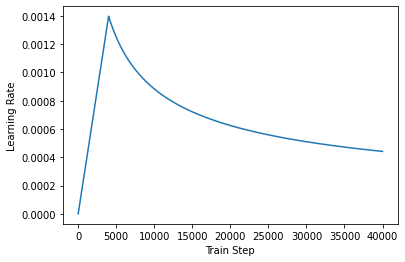

In [57]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [58]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [59]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [60]:
def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [61]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [62]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    rate=dropout_rate)

In [68]:
def training_func(inp,tar):
    tar_input = tar[:,:-1]
    tar_real = tar[:,1:]
    with tf.GradientTape() as tape:
        preds,_ = transformer((inp,tar_input),training=True)
        loss = loss_function(tar_real,preds)
    gradients = tape.gradient(loss,transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients,transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, preds))

In [66]:
EPOCHS = 20

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    training_func(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8861 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8460 Accuracy 0.0004
Epoch 1 Batch 100 Loss 8.7671 Accuracy 0.0147
Epoch 1 Batch 150 Loss 8.6477 Accuracy 0.0306
Epoch 1 Batch 200 Loss 8.4976 Accuracy 0.0399
Epoch 1 Batch 250 Loss 8.3210 Accuracy 0.0460
Epoch 1 Batch 300 Loss 8.1261 Accuracy 0.0504
Epoch 1 Batch 350 Loss 7.9244 Accuracy 0.0540
Epoch 1 Batch 400 Loss 7.7341 Accuracy 0.0606
Epoch 1 Batch 450 Loss 7.5643 Accuracy 0.0682
Epoch 1 Batch 500 Loss 7.4140 Accuracy 0.0765
Epoch 1 Batch 550 Loss 7.2770 Accuracy 0.0845
Epoch 1 Batch 600 Loss 7.1499 Accuracy 0.0921
Epoch 1 Batch 650 Loss 7.0293 Accuracy 0.1003
Epoch 1 Batch 700 Loss 6.9119 Accuracy 0.1091
Epoch 1 Batch 750 Loss 6.8007 Accuracy 0.1179
Epoch 1 Batch 800 Loss 6.6904 Accuracy 0.1272
Epoch 1 Loss 6.6709 Accuracy 0.1290
Time taken for 1 epoch: 15844.14 secs

Epoch 2 Batch 0 Loss 4.9110 Accuracy 0.2768
Epoch 2 Batch 50 Loss 4.7938 Accuracy 0.3049
Epoch 2 Batch 100 Loss 4.7174 Accuracy 0.3143
Epoch 2 Bat